# Regressão Logística usando Softmax (Iris dataset) implementação matricial

O objetivo deste notebook é 
* ilustrar a implementação, treino e uso de um classificador multiclasse utilizando 
* regressão logística e 
* componente softmax e
* minimização da função perda utilizando gradiente descendente. 

O conjunto de dados utilizados é o Iris, utilizando apenas 
* dois atributos para 
* visualização das fronteiras de decisão no espaço de atributos.

Como feito no experimento de Regressão Linear, as funções serão todas implementadas utilizando apenas o NumPy e serão uma extensão do problema de Regressão Linear.


## Classificador Supervisionado

O problema neste exemplo é um dos muitos que desenvolveremos neste curso e está na categoria de classificador supervisionado:

Dado um conjunto de amostras rotuladas, isto é, cada amostra será caracterizada pelos seus atributos e será representada na matriz $\boldsymbol{X}$ de shape $(n,k)$: ($n$ amostras e $k$ classes. Adicionalmente, cada amostra possui uma classe, um rótulo ou categoria, representado pelo vetor $\boldsymbol{Y}$ com $n$ elementos, cada um indicando a classe a qu pertence.

No caso da Iris, serão:
* 150 amostras, 50 da setosa (classe 0), virginica (classe 1) e versicolor (classe 2).

O par $(\boldsymbol{X},\boldsymbol{Y})$ consiste de um conjunto de dados anotados ou rotulados.

Uma das principais dificuldades no projeto de classificadores supervisionados é a criação deste banco anotado, pois demanda um esforço e conhecimento de peritos, muitas vezes tornando o problema inviável.

## Definição do problema

Dado o conjunto rotulado $(\boldsymbol{X},\boldsymbol{Y})$, projetar um classificador que dada uma nova amostra desconhecida, classifique-a em uma das possíveis classes: setosa, virginica ou versicolor.

Iremos utilizar uma solução baseada no experimento da Regressão Linear, porém agora, utilizando dois atributos e projetando o classificar para 3 classes. A minimização da função perda também será feita pelo método do gradiente descendente.

## Importação de bibliotecas

Objetivo deste exemplo é codificar o método de Regressão Logística utilizando Softmax e
gradiente descendente. As bibliotecas usadas são:
* NumPy - processamento matricial
* sklearn - apenas para carregar o dataset
* matplotlib - gerar gráficos
* pandas - mostrar a matriz de confusão
* IPython - permite mostrar os dados na forma de tabela


In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display

## Iris Flower Dataset

[Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set): The data set consists of 50 samples from each of three species of Iris (*Iris setosa, Iris virginica and Iris versicolor*). Four features were measured from each sample: the **length and the width of the sepals and petals, in centimetres**. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

## Escolhendo os dois atributos

Dos 4 atributos disponíveis: comprimento e largura das sépalas e comprimento e largura das pétalas, vamos escolher 2 apenas: o comprimento das sépalas e o comprimento das pétalas.

O conjunto de dados rotulados estão é formado por:
* Y: vetor de 150 amostras contendo o valor da classe da amostra: 0, 1 ou 2
* X: contendo 150 amostras (linhas) e duas colunas:
    * coluna 0: o comprimento das sépalas e 
    * coluna 1: comprimento das pétalas.
    
O trecho a seguir faz a leitura dos dados, escolha das duas colunas (0 e 2) e a impressão dos shapes de `X` e `Y`. Ambos formam nosso conjunto de dados anotados.


In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
Y = iris.target
print 'X.shape:',X.shape
print 'Y.shape:',Y.shape

X.shape: (150, 2)
Y.shape: (150,)


## Imprimindo os dados rotulados com pandas

O panda é um pacote extremamente poderoso para processamento e visualização de dados. Vamos utilizá-lo aqui para melhor visualizar os dados X e Y na forma de tabela.

In [3]:
# Assuming that dataframes df1 and df2 are already defined:
df = pd.DataFrame(X, index=Y, columns=['comprimento sepalas','comprimento petalas'])
df.columns.name = 'classe'
print 'Imprimindo primeiros 5 amostras'
display(df.head()) # imprime o começo da tabela
print 'Imprimindo 5 últimas amostras'
display(df.tail()) # imprime o final

Imprimindo primeiros 5 amostras


classe,comprimento sepalas,comprimento petalas
0,5.1,1.4
0,4.9,1.4
0,4.7,1.3
0,4.6,1.5
0,5.0,1.4


Imprimindo 5 últimas amostras


classe,comprimento sepalas,comprimento petalas
2,6.7,5.2
2,6.3,5.0
2,6.5,5.2
2,6.2,5.4
2,5.9,5.1


## Visualizando o dataset

Como feito no notebook passado, as amostras são visualizadas com o `scatter`. A cor de cada amostra é selecionada pela sua classe: 0: red, 1: yellow: 2: blue. A cor é indexada pelo vetor `Y` das classes.

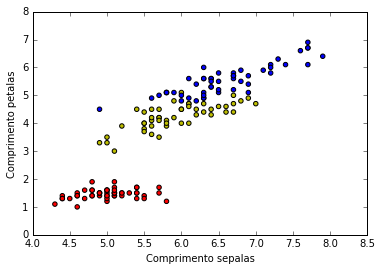

In [4]:
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Normalização dos dados

A normalização dos dados quando existem mais de um atributo merece um cuidado, pois os limites dos valores mínimos e máximos devem ser feitos para cada atributo. Em NumPy isso é conseguido com a operação de redução de eixo onde é possível encontrar o máximo e o mínimo por colunas ou por linhas. No caso, como os atributos estão organizados por colunas, a redução deve ocorrer no eixo das linhas (axis=0):

Para se observar a diferença entre a normalização certa e que normaliza de forma global, fazemos as duas normalizações e visualizamos para observar a diferença.

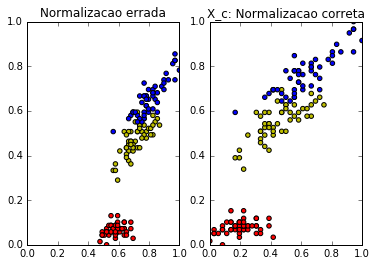

In [5]:
# normalização global - não deve ser usada
X_a = X - X.min()
X_a /= X_a.max()

# normalização correta - por coluna
X_c = X - X.min(axis=0,keepdims=True)
X_c /= X_c.max(axis=0,keepdims=True)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlim(0,1)
ax1.scatter(X_a[:, 0], X_a[:, 1], c=colors[Y])
ax2.scatter(X_c[:, 0], X_c[:, 1], c=colors[Y])
ax1.set_title('Normalizacao errada')
ax2.set_title('X_c: Normalizacao correta')


## Função para codificar rótulos inteiros na codificação one-hot

Esta função é também chamada de conversão para dados categóricos. Temos 3 classes de
flores: Iris setosa, Iris virginica and Iris versicolor. Estas classes podem ser codificadas
como classes 0, 1 e 2 (rótulos numéricos) ou na codificação com 3 variáveis binárias:

<table border="1">
<tr>
<td>Espécie</td>
<td>Y</td>
<td>Y_oh[0]</td>
<td>Y_oh[1]</td>
<td>Y_oh[2]</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>0</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>1</td>
<td>0</td>
<td>1</td>
<td>0</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>2</td>
<td>1</td>
<td>0</td>
<td>1</td>
</tr>
</table>



A função `oneHotIt` a seguir implementa de forma eficiente esta conversão, utilizando a
facilidade de criação de arrays esparsos.

A entrada da função é o vetor `Y` e a saída será um array com o mesmo número de
linhas que o número de elementos de `Y` e a largura terá o número de colunas do
maior rótulo disponível em `Y`:

A título de ilustração e exercício de programação matricial, apresentamos a seguir duas implementações da função que converte os labels para a codificação "one-hot":

In [6]:
def oneHotIt2(Y,k):
    Y = Y.reshape(-1,1)
    i = np.arange(k).reshape(1,k)
    Y_oh = (Y == i).astype(int)
    return Y_oh

def oneHotIt(Y,k):
    n = Y.size # número de amostras
    i = np.arange(n)
    Y_oh = np.zeros(shape=(n,k))
    Y_oh[i,Y] = 1
    return Y_oh

### Gerando vetor de rótulos no formato one-hot 

In [7]:
Y_oh = oneHotIt(Y,3)
# Mostrando os primeiros 5 destes valores
print 'Y[:5]:\n', Y[:5]
print 'Y_oh[:5]=\n',Y_oh[:5]
print 'Y[-5:]:\n', Y[-5:]
print 'Y_oh[-5:]=\n',Y_oh[-5:]

Y[:5]:
[0 0 0 0 0]
Y_oh[:5]=
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]
Y[-5:]:
[2 2 2 2 2]
Y_oh[-5:]=
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


## Colocando a coluna 0 em X com 1s como o 'bias'

Conforme visto no exercício da Regressão Linear, a equação linear de y em função de x0, x1, x_k tem um fator independente de x, denominado bias. Inserindo-se a coluna 0 de X com 1, é equivalente a definir o w0 como bias.

In [8]:
X_bias = np.hstack([np.ones((150,1)),X_c]) # incluído X00 como 1 para gerar bias no W
print 'X_bias[:5]=\n',X_bias[:5]

X_bias[:5]=
[[ 1.          0.22222222  0.06779661]
 [ 1.          0.16666667  0.06779661]
 [ 1.          0.11111111  0.05084746]
 [ 1.          0.08333333  0.08474576]
 [ 1.          0.19444444  0.06779661]]


## Função `softmax`

A funcão Softmax já foi vista antes:
Revisando, a implementação matricial usando o NumPy é baseado na equação matricial, repetida aqui:

$$ Softmax(\boldsymbol{Z}) = \frac{e^{\boldsymbol{Z}}}{\sum_{j=0}^{k-1}e^{z_{i,j}}} $$


In [9]:
def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True) # normaliza nas classes - colunas
    return S

## Esquema genérico do classificar supervisionado - treinamento e predição

A figura a seguir ilustra o diagrama do classificador supervisionado multiclasse utilizando regressão logística e softmax.

Podemos identificar os blocos responsáveis pelo treinamento do classificador:
* $\boldsymbol{(Y,X)}$ são os dados rotulados
* $\boldsymbol{W}$, são os parâmetros a serem treinados
* Softmax é o que converte os scores de $\boldsymbol{XW}$ para probabilidades, gerando o $\hat{Y_{OH}}$
* O.H. converte o rótulo original em "one-hot"
* $J$ é a função perda que compara $ Y_{OH}$ e $\hat{Y_{OH}}$ a ser minimizada
* $\Delta_WJ$ é o gradiente que será utilizado para atualizar o $\boldsymbol{W}$ pelo método do gradiente descendente.

Os blocos responsáveis pela predição, uma vez que $\boldsymbol{W}$ já seja treinado:
* Softmax(XW) para calcular as probabilidades
* `Argmax` para escolher a classe de maior probabilidade

![](../figures/regressaologistica_fluxo.jpg)


## J: Função Perda pela Entropia Cruzada

A função a ser minimizada é a função $J$ de perda, que é baseada na Entropia Cruzada (*Cross Entropy*). Dado um conjunto de **amostras anotadas**, isto é, amostras $\boldsymbol{X}$ com
classe $\boldsymbol{Y}$, encontrar os pesos $\boldsymbol{W}$ que minimizam $J$:

$$ J_{\boldsymbol{X,Y}_{TRUE}}(\boldsymbol{W}) = -\frac{1}{n} \sum \boldsymbol{Y}_{TRUE} \odot \log{\boldsymbol{S}(\boldsymbol{XW})}$$
onde $\odot$ é multiplicação ponto-a-ponto de matrizes.

### Minimização pelo gradiente descendente

A minimização é feita através do método de gradiente descendente. O gradiente de $J$ é dado por:

$$ \boldsymbol{\Delta J(W)} = - \frac{1}{n} \boldsymbol{X}^T (\boldsymbol{Y}_{TRUE} - \boldsymbol{S(XW)}) $$ 

Os pesos são então ajustados em cada *batch* pela equação onde $\eta$ é denominado de
taxa de aprendizagem: *learning rate*:

$$ \boldsymbol{W} = \boldsymbol{W} - \eta \boldsymbol{\Delta J(W)} $$ 

A cada iteração no programa de minimização abaixo, os pesos são ajustados aplicando-se o
gradiente descendente utilizando todo o conjunto de treinamento. Este esquema é denominado
de "batch gradient descent".

No programa a seguir, o $J$ é implementado pela variável `loss` e o gradiente $\Delta J$ 
é implementado pela variável `Grad`.

### Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

In [10]:
n = X_bias.shape[0] # number of training examples
m = X_bias.shape[1] # number of attributes (features + 1(bias))
k = 3          # number of classes
W = np.zeros([m,k]) # n. de linhas é igual a número de atributos (features, pixels)
iterations = 10000
learningRate = 0.15

losses = []
for i in range(iterations):
    scores = X_bias.dot(W)
    S = softmax(scores)
    loss = (-1. / n) * np.sum(Y_oh * np.log(S))
    Grad = (-1. / n) * (X_bias.T).dot(Y_oh - S) 
    W = W - (learningRate * Grad)
    losses.append(loss)
print 'final W:\n',W
print 'Final loss:',loss

final W:
[[  7.00966877   1.62753812  -8.63720689]
 [ -3.02197327   1.76353      1.25844327]
 [-14.71228144  -0.67161669  15.38389814]]
Final loss: 0.206986527354


## Visualizando a minimização da Perda durante o treinamento

É fundamental acompanhar o comportamento da Perda durante o treinamento, pois é difícil prever se os parâmetros do gradiente descendente estão bons.

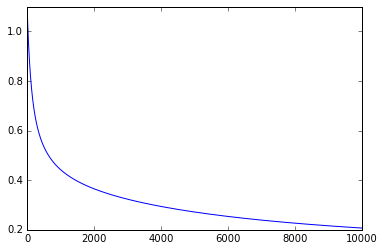

In [11]:
plt.plot(losses)

## Função `predict`

A função predict escolhe a classe de maior probabilidade a partir do resultado do `softmax`:
Entrada:
- X: matriz bidimensional (n,m): n amostras e m attributes - AMOSTRAS
- W: matriz bidimensional (m,k): m attributes e k classes - PESOS TREINADOS
Saída:
- Y_hat: matriz bidimensional (n,1): n amostras x 1 - CLASSE prevista


In [12]:
def predict(X,W):
    S = softmax(X.dot(W))
    # escolhe a maior probabilidade entre as classes
    Y_hat = np.argmax(S,axis=1)
    return Y_hat

## Cálculo do desempenho do resultado

A acurácia é o número de acertos dividido pelo número de amostras $n$.

$$ Acc(Y,\hat{Y}) = \frac{1}{n} \sum_{i=0}^{n-1} 1(Y_i = \hat{Y}_i $$

In [13]:
Y_hat = predict(X_bias,W)

accuracy = np.sum(Y_hat == Y)/np.float(n)

print 'Acurácia: ', accuracy

print 'Matriz de confusão:'
import pandas as pd
pd.crosstab(predict(X_bias,W), Y)


Acurácia:  0.96
Matriz de confusão:


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Visualizando a regiões do classificador no espaço de atributos

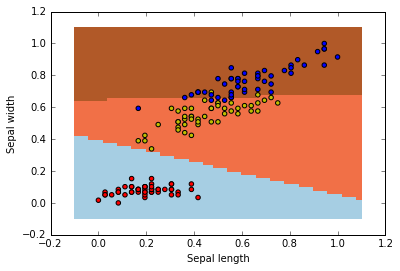

In [14]:
h = .02  # step size in the mesh
folga = 0.1
# Calcula a grade para o espaço de atributos

x_min, x_max = X_c.min(axis=0) - folga, X_c.max(axis=0) + folga
xx, yy = np.meshgrid(np.arange(x_min[0], x_max[0], h), np.arange(x_min[1], x_max[1], h))
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid = np.hstack([np.ones((X_grid.shape[0],1)),X_grid]) # incluído X00 como 1 para gerar bias no W

# Faz a predição para todas as amostras do espaço de atributos
Z = predict(X_grid, W)

# Mostra o resultado da predição (0, 1 ou 2) no gráfico
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Mostra os pontos das amostras de treinamento
colors = np.array(['r','y','b'])
plt.scatter(X_bias[:, 1], X_bias[:, 2], c=colors[Y], edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## Atividades

1. O próximo notebook é similar a este, porém com a visualização simultânea do gráfico da perda e o gráfico das fronteiras de decisão. Faça as atividades neste próximo notebook e utilize este para entender os diversos passos do programa, pois aqui o notebook está bastante explicado.